In [1]:
import numpy as np
import matplotlib.pyplot as plt
from eigenfaces import DimensionalityReduction
from sklearn.decomposition import PCA

from faceProcessing import create_vector_and_matrix
from facesExample import dictionary_of_names, dictionary_of_mathematicians
from helper_functions import reconstruct_images, plot_images, get_closest_point

First we load our images, image_matrix contains pixel data of each image, image_vector contains labels (extensions in this case)

In [2]:
image_vector, image_matrix = create_vector_and_matrix('https://sluzby.fmph.uniba.sk/f/', list(dictionary_of_names.keys()))
mathematician_vector, mathematician_matrix = create_vector_and_matrix('', list(dictionary_of_mathematicians.values()))

We can reconstruct each image by using reconstruct_images function

In [18]:
original_images = reconstruct_images(image_matrix, 100, 100)
mathematician_images = reconstruct_images(mathematician_matrix, 100, 100)

In [19]:
print(image_matrix.shape)
print(mathematician_matrix.shape)

(174, 10000)
(5, 10000)


Small sample of our images

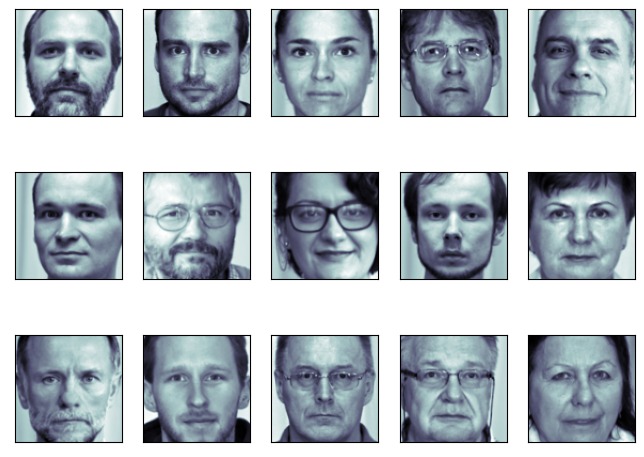

In [20]:
plot_images(original_images, 3, 5)

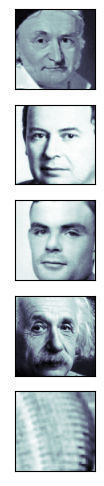

In [22]:
plot_images(mathematician_images, len(mathematician_images), 1)

First PCA is imported from sklearn, second PCA, pca_alt, is our own version. 
pca_alt will be used mostly for comparison. 
Setting the n_components parameter to value 0<n<1 gives us the required amount of components needed to achieve explained variance >=n

In [23]:
pca = PCA(n_components = 0.95, whiten = True)
reduced_image_matrix = pca.fit_transform(image_matrix)
reduced_math_image_matrix = pca.transform(mathematician_matrix)

In this case its 75 components

In [24]:
pca.components_.shape

(75, 10000)

In [25]:
pca_alt = DimensionalityReduction()
reduced_image_matrix_alt = pca_alt.fit_transform(image_matrix, 150)

These are the average faces calculated from both algorithms (sklearn pca is first image, ours is second)

In [26]:
avg_face_1 = reconstruct_images([pca.mean_], 100, 100)[0]
avg_face_2 = reconstruct_images([pca_alt.avg_vector[0]], 100, 100)[0]

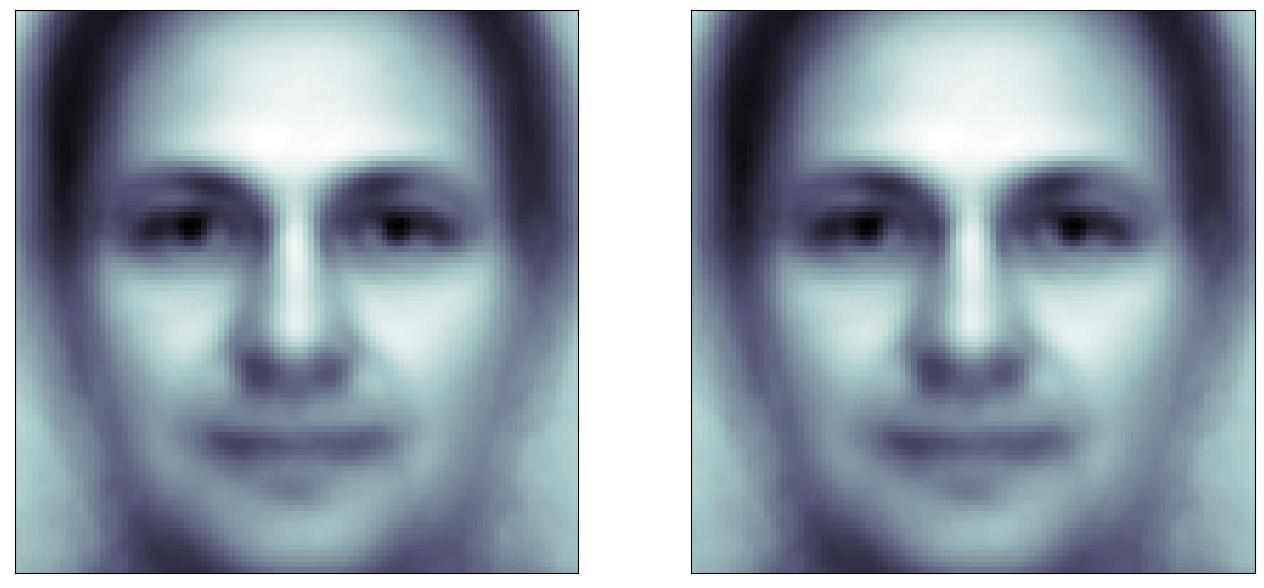

In [27]:
plot_images([avg_face_1, avg_face_2], 1, 2, (16, 16))

In [28]:
feature_faces = reconstruct_images(pca.components_[:30], 100, 100)
feature_faces_alt = reconstruct_images(pca_alt.e_vec.T[:30,:], 100, 100)

These are the feature faces of sklearn pca

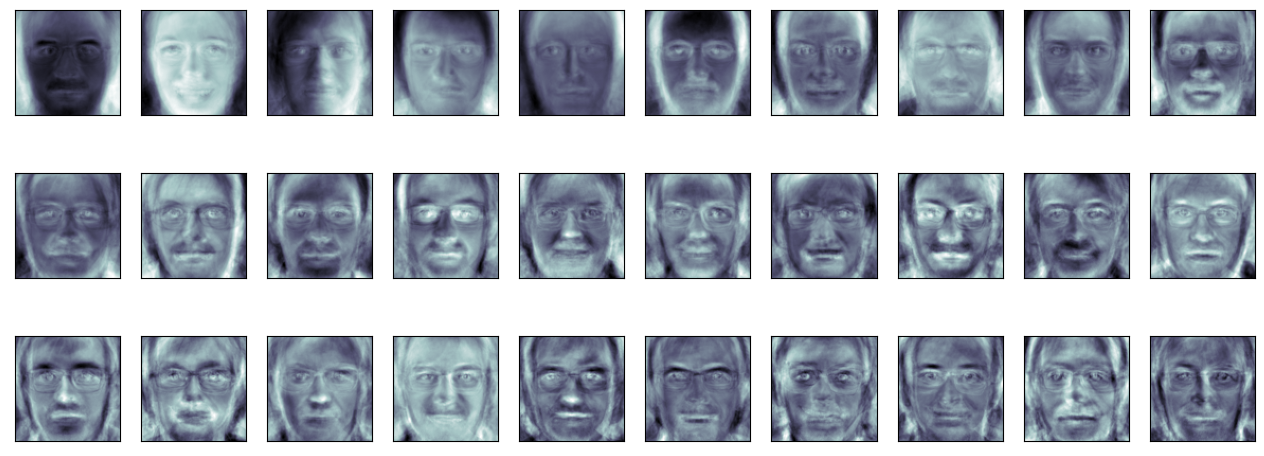

In [29]:
plot_images(feature_faces, 3, 10, (16,6))

feature faces made using our algorithm, they are very similar, though not completely identical, lot of features seem to just have their lightning flipped

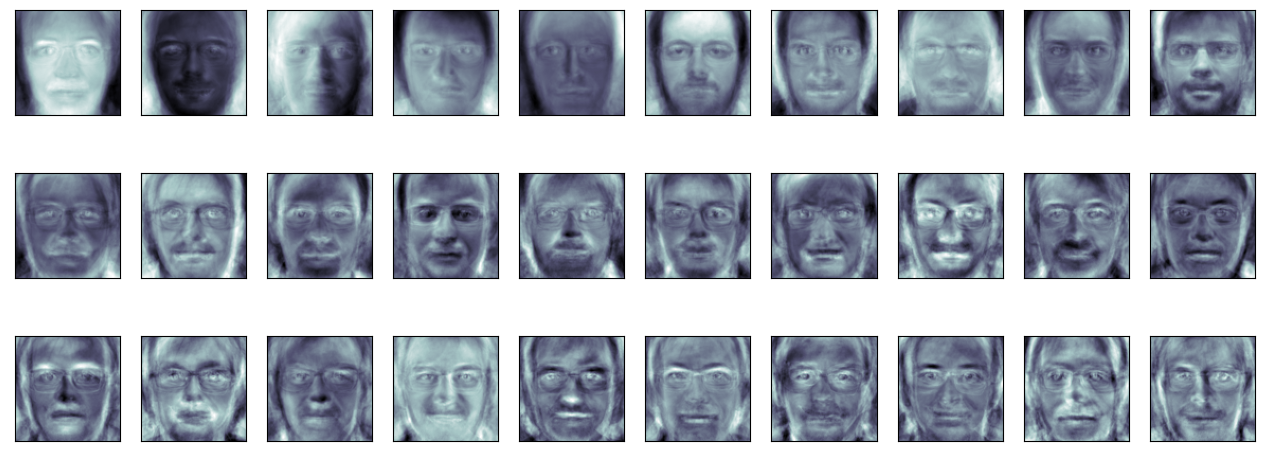

In [30]:
plot_images(feature_faces_alt, 3, 10, (16,6))

This was just a little test to see, if we can find some ineteresting combination of features, but they dont really group well together

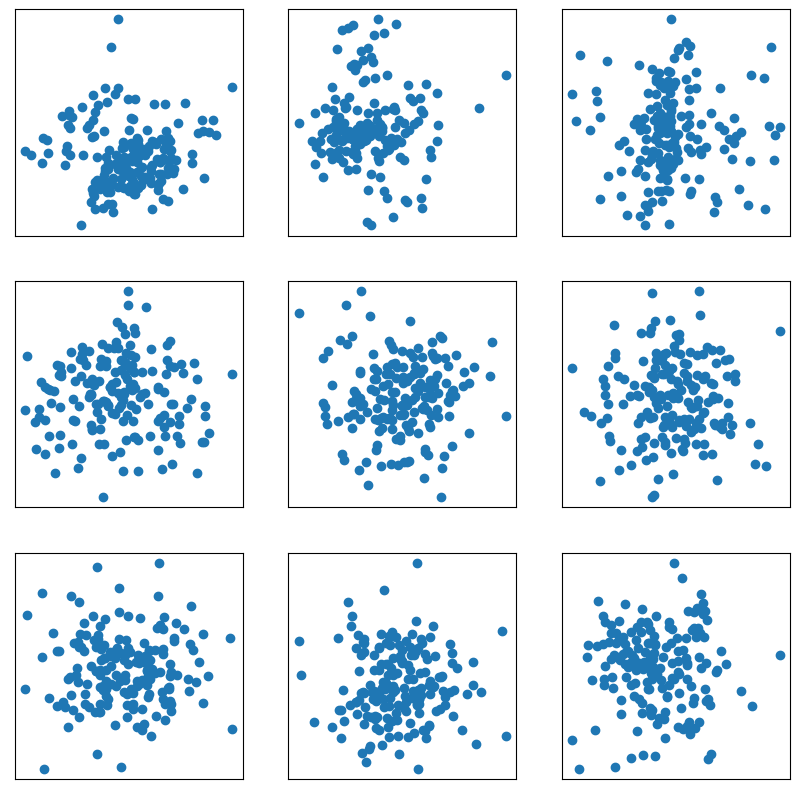

In [31]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.scatter(reduced_image_matrix[:, i], reduced_image_matrix[:, i + 1])
#plt.scatter(image_matrix[:, 5], image_matrix[:, 15])
#plt.show()

Here we search for faculty members who most resemble famous mathematicians, last one is kinda sorta questionable

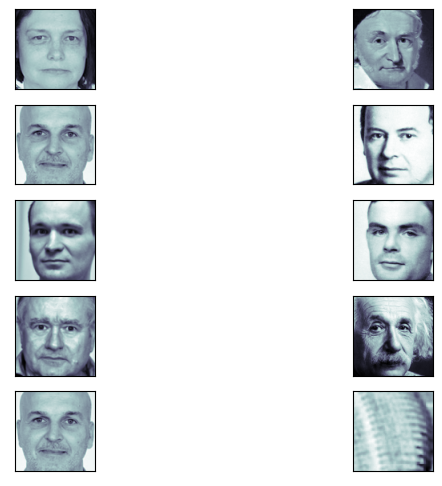

In [67]:
feature_num = 15
closest_images = []
for image in reduced_math_image_matrix:
    closest_images.append(get_closest_point(reduced_image_matrix[:, :feature_num], image[:feature_num]))

fig = plt.figure(figsize=(8, 6))
for i, idx in enumerate(closest_images):
    ax = fig.add_subplot(len(reduced_math_image_matrix), 2, i*2 + 1, xticks=[], yticks=[])
    ax.imshow(original_images[idx], cmap=plt.cm.bone)
    ax = fig.add_subplot(len(reduced_math_image_matrix), 2, i*2 + 2, xticks=[], yticks=[])
    ax.imshow(mathematician_images[i], cmap=plt.cm.bone)

CLUSTERING PART

We test 3 different clustering methods:
1. Sklearn kmeans
2. Our own kmeans
3. Gaussian Mixture algorithm

In [33]:
from sklearn.cluster import KMeans
from eigenfaces import ClusteringKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Using silhouetter_score and elbow method, we can determine the optimal amount of clusters for our algorithm. 
https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

In [34]:
### Some params we can adjust
r_state = 4
kmax = 100
first_c = 0 # first feature we take into consideration
last_c = 15 # last feature we take into consideration

In [35]:
sil = []
inertia = []
for i in range(2, kmax+1):
    kmeans = KMeans(n_clusters = i, n_init = 10, random_state = r_state).fit(reduced_image_matrix[:, first_c:last_c])
    labels = kmeans.labels_
    sil.append(silhouette_score(reduced_image_matrix[:, first_c:last_c], labels, metric = 'euclidean'))
    inertia.append(kmeans.inertia_)
    
optimal_n_of_clusters = sil.index(max(sil)) + 2

Here we can see the optimal amount of clusters (according to silhouette score)

In [36]:
print(optimal_n_of_clusters)

30


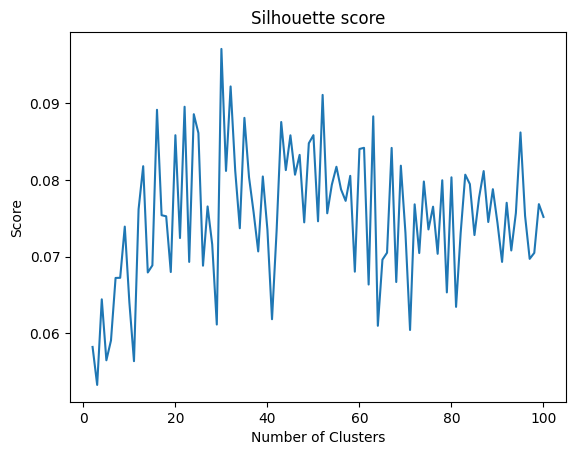

In [37]:
plt.plot(range(2, kmax+1), sil)
plt.title('Silhouette score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

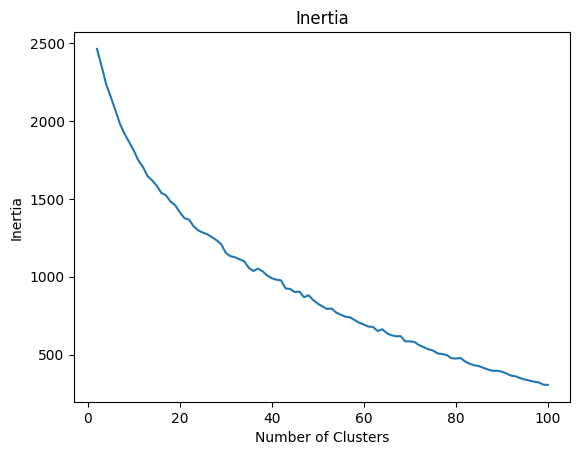

In [38]:
plt.plot(range(2, kmax+1), inertia)
plt.title('Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

We will use these values to create seemingly optimal clustering

In [62]:
kmeans = KMeans(n_clusters = optimal_n_of_clusters, n_init = 10, random_state = r_state).fit(reduced_image_matrix[:, first_c:last_c])
y_labels = kmeans.labels_
groups = [[] for i in range(optimal_n_of_clusters)]
for i in range(len(y_labels)):
    groups[y_labels[i]].append(original_images[i])

In [63]:
for i, group in enumerate(groups):
    print(f'Group {i}: {len(group)}')

Group 0: 8
Group 1: 8
Group 2: 9
Group 3: 8
Group 4: 7
Group 5: 5
Group 6: 7
Group 7: 13
Group 8: 5
Group 9: 6
Group 10: 23
Group 11: 10
Group 12: 7
Group 13: 9
Group 14: 4
Group 15: 9
Group 16: 4
Group 17: 10
Group 18: 7
Group 19: 10
Group 20: 5


This is a solid representative group

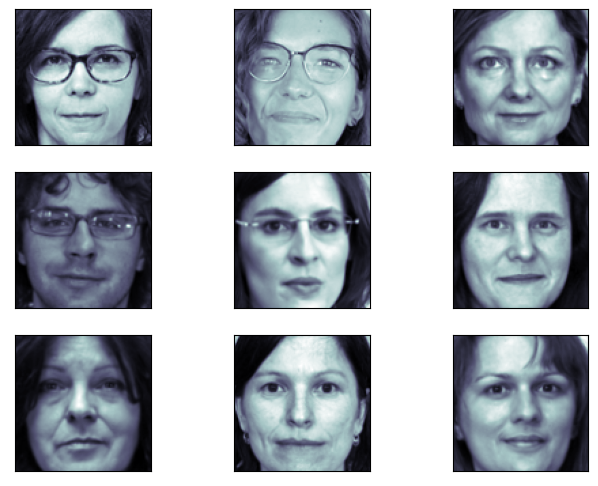

In [66]:
plot_images(groups[2], 3, 3)

We can apply the elbow method to our own algorithm

In [42]:
inertia = []
for i in range(2, kmax+1):
    ckmeans = ClusteringKMeans(n_clusters = i, k_dimensions = last_c)
    ckmeans.fit(image_matrix)
    inertia.append(ckmeans._inertia)

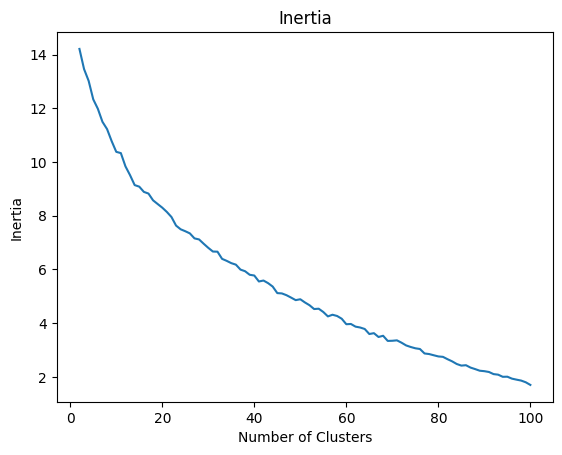

In [43]:
plt.plot(range(2, kmax+1), inertia)
plt.title('Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [57]:
ckmeans = ClusteringKMeans(n_clusters = optimal_n_of_clusters, k_dimensions = last_c)
ckmeans.fit(image_matrix)
labels = ckmeans.predict(image_matrix)
groups = [[] for i in range(optimal_n_of_clusters)]
for i in range(len(labels)):
    groups[labels[i]].append(original_images[i])

In [58]:
for i, group in enumerate(groups):
    print(f'Group {i}: {len(group)}')

Group 0: 5
Group 1: 17
Group 2: 14
Group 3: 14
Group 4: 12
Group 5: 6
Group 6: 13
Group 7: 14
Group 8: 7
Group 9: 5
Group 10: 2
Group 11: 9
Group 12: 4
Group 13: 3
Group 14: 6
Group 15: 7
Group 16: 8
Group 17: 13
Group 18: 2
Group 19: 8
Group 20: 5


Pretty successful group

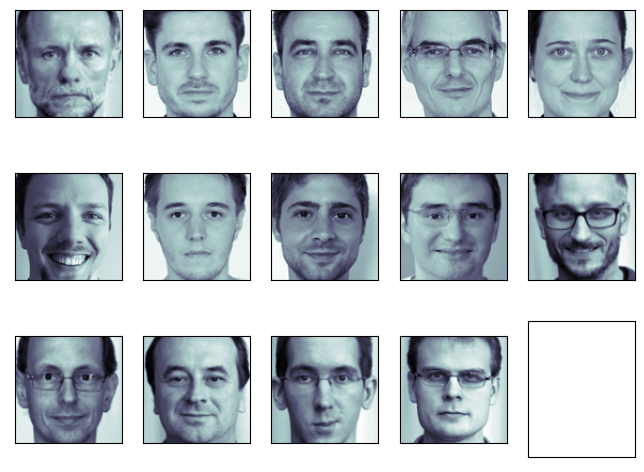

In [61]:
plot_images(groups[2],3, 5)

Lastly we try the Gauissian Mixture algorithm

In [47]:
model = GaussianMixture(n_components=optimal_n_of_clusters, random_state = r_state)
model.fit(reduced_image_matrix[:, first_c:last_c])
labels = model.predict(reduced_image_matrix[:, first_c:last_c])

In [48]:
groups = [[] for i in range(optimal_n_of_clusters)]
for i in range(len(labels)):
    groups[labels[i]].append(original_images[i])

In [49]:
for i, group in enumerate(groups):
    print(f'Group {i}: {len(group)}')

Group 0: 12
Group 1: 5
Group 2: 14
Group 3: 4
Group 4: 12
Group 5: 6
Group 6: 6
Group 7: 5
Group 8: 9
Group 9: 5
Group 10: 1
Group 11: 3
Group 12: 4
Group 13: 8
Group 14: 6
Group 15: 5
Group 16: 7
Group 17: 3
Group 18: 10
Group 19: 2
Group 20: 4
Group 21: 3
Group 22: 3
Group 23: 9
Group 24: 8
Group 25: 1
Group 26: 5
Group 27: 3
Group 28: 6
Group 29: 5


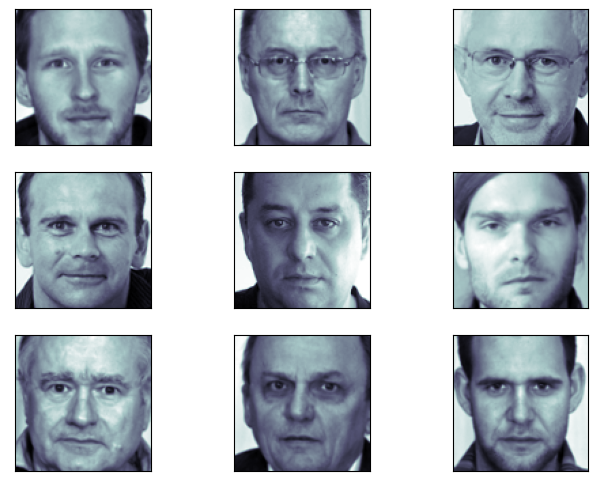

In [50]:
plot_images(groups[0], 3, 3)

Its difficult to objectively assess the accuracy of our models, since we have many dimensions and we are only clustering the faces, based on their visual similarity (features). The Gaussian Mixture seems to produce worse results than the two former algorithms, but that may be due to having non optimal parameters

In [51]:
from helper_functions import create_colors

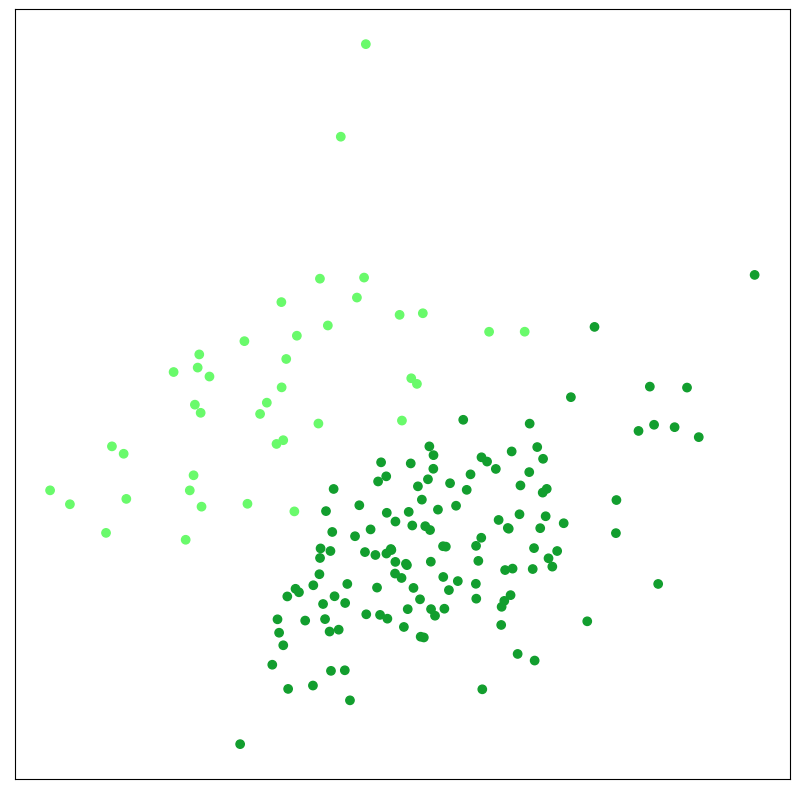

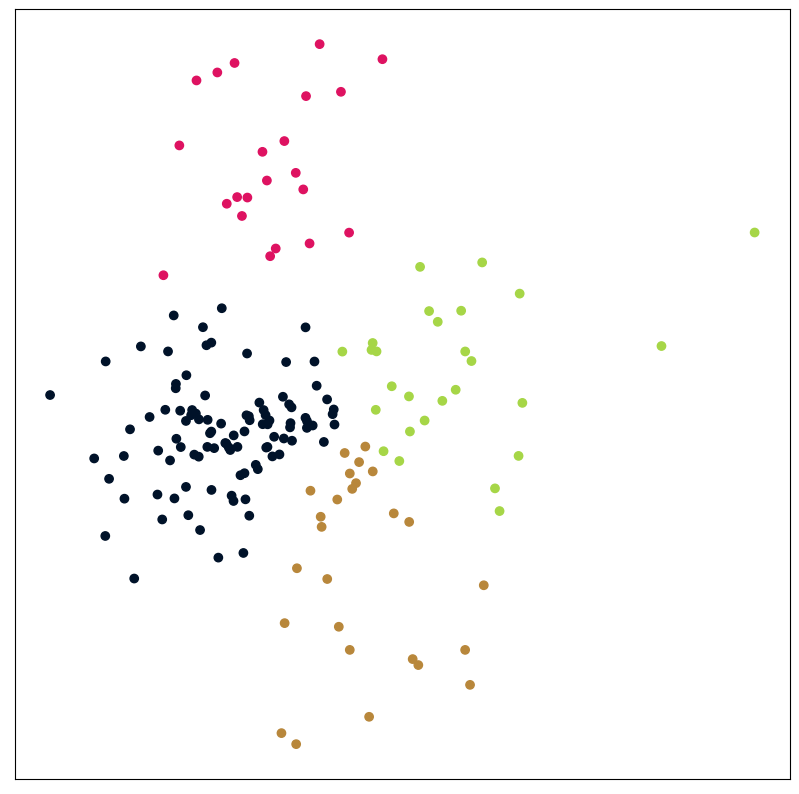

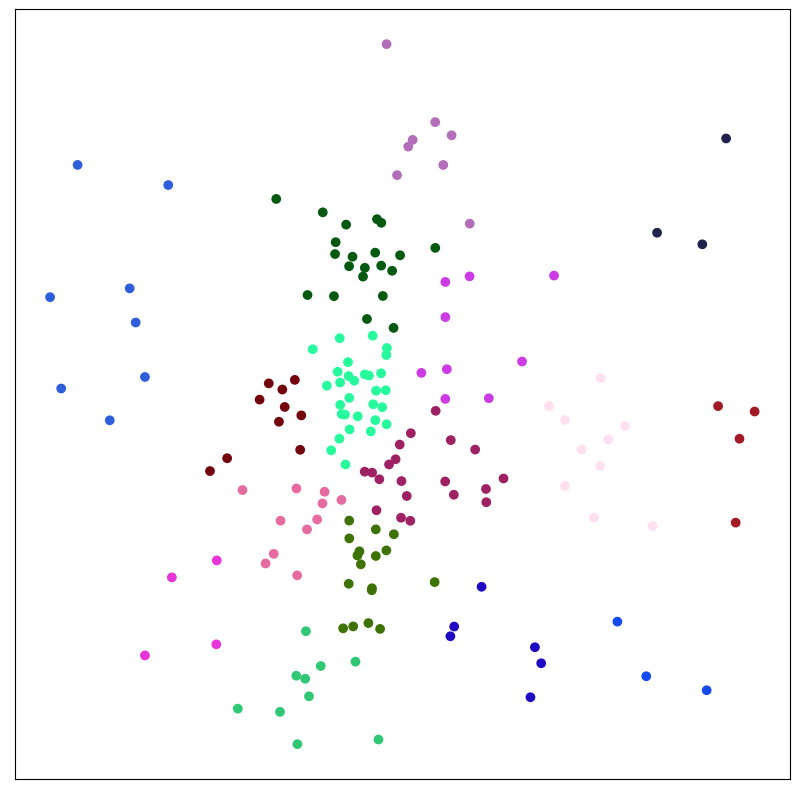

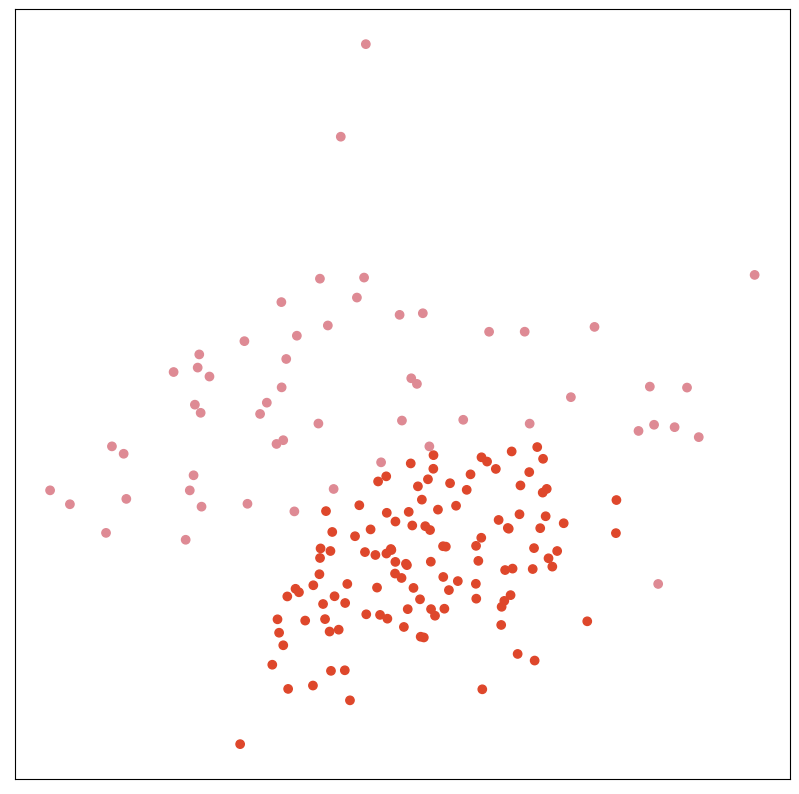

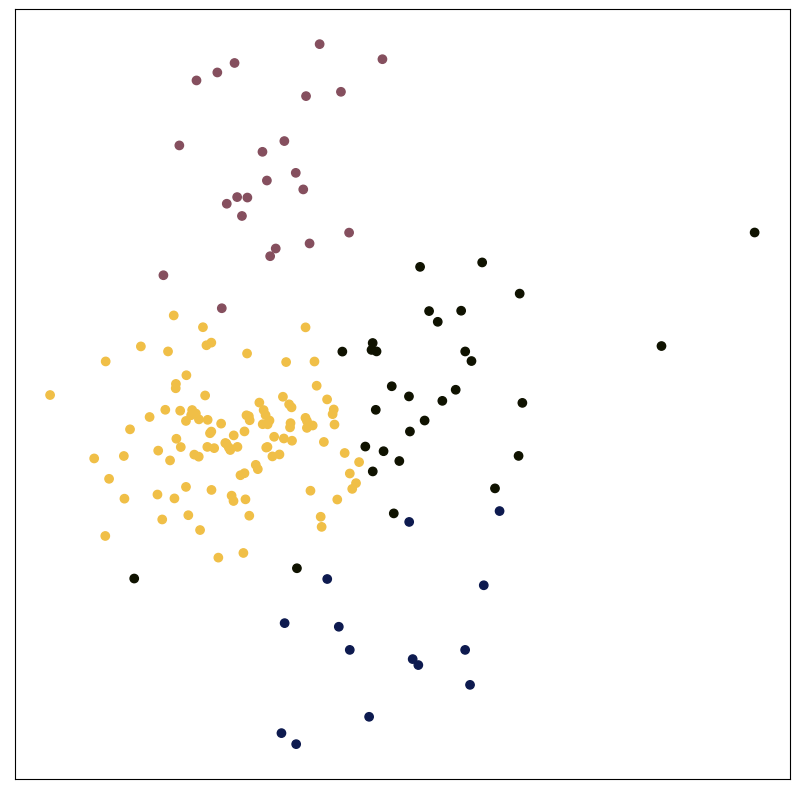

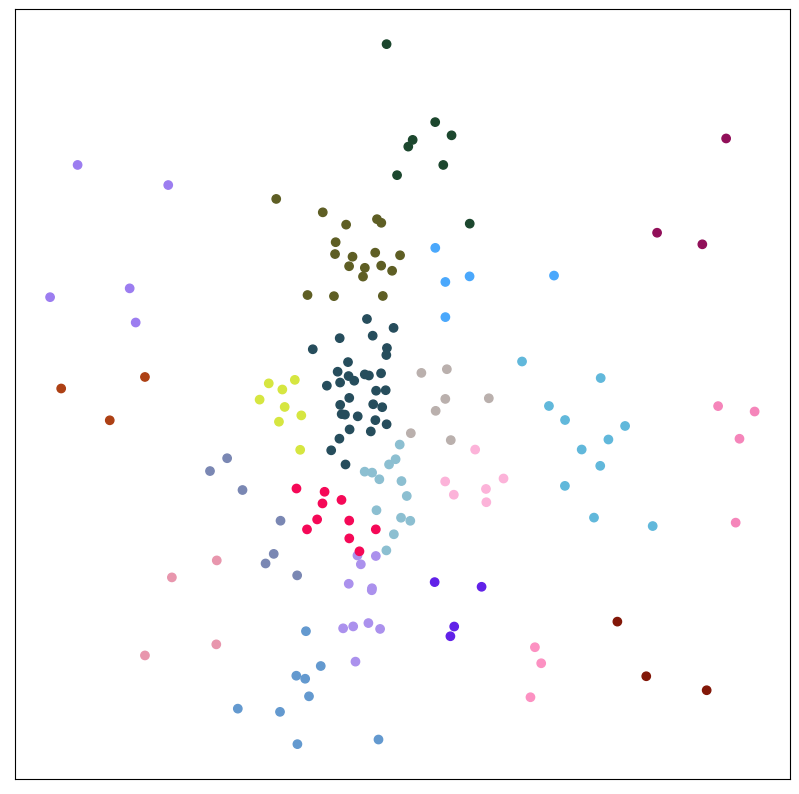

In [52]:
kmax = 25
for j in range(0, 3):
    sil = []
    for i in range(2, kmax+1):
        kmeans = KMeans(n_clusters = i, n_init = 10, random_state = r_state)
        kmeans.fit(reduced_image_matrix[:, [j, j+1]])
        labels = kmeans.labels_
        sil.append(silhouette_score(reduced_image_matrix[:, [j, j+1]], labels, metric = 'euclidean'))

    optimal_n_of_clusters = sil.index(max(sil)) + 2
    kmeans = KMeans(n_clusters = optimal_n_of_clusters, n_init = 10, random_state = r_state).fit(reduced_image_matrix[:, [j, j+1]])
    labels = kmeans.labels_
    cols = create_colors(labels, optimal_n_of_clusters)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    ax.scatter(reduced_image_matrix[:, j], reduced_image_matrix[:, j + 1], c = cols)


for j in range(0, 3):
    sil = []
    for i in range(2, kmax+1):
        model = GaussianMixture(n_components = i, random_state = r_state)
        model.fit(reduced_image_matrix[:, [j, j+1]])
        labels = model.predict(reduced_image_matrix[:, [j, j+1]])
        sil.append(silhouette_score(reduced_image_matrix[:, [j, j+1]], labels, metric = 'euclidean'))

    optimal_n_of_clusters = sil.index(max(sil)) + 2
    model = GaussianMixture(n_components=optimal_n_of_clusters, random_state = r_state)
    model.fit(reduced_image_matrix[:, [j, j+1]])
    labels = model.predict(reduced_image_matrix[:, [j, j+1]])
    cols = create_colors(labels, optimal_n_of_clusters)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    ax.scatter(reduced_image_matrix[:, j], reduced_image_matrix[:, j + 1], c = cols)
